# Analysis of the impact of metro station location on commuter bikeshare habits
In this notebook I will attempt to answer the following questions using 1 year (~3.25 million rides in 386MB) of Capital Bikeshare data
* how does bike share ride frequency change throughout the day?
* how does weekend vs. weekday bike share ridership vary?
* how does rush hour ridership compare to non-rush hour?
* how do the most popular stations and routes vary between these different time windows?
* how does ride distance vary between these windows?
* can we identify gaps in service by looking at how far a commuter is willing to ride a bike?
* can we correlate any changes in ridership to delays along certain metro lines?

In [2]:
import pickle
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
from geopy.distance import vincenty
import folium
matplotlib.style.use('ggplot')
%matplotlib inline

Load data which has been previous imported and cleaned in other notebooks
* `bike_location` is a dictionary of all Capital Bikeshare stations (key) and their geo-coordinates (value)
* `station_data` is a 2D dictionary of the metro stations (2nd level key) along each line (1st level key) and their geo-coordinates (2nd level values)
* `metro_delays` is a pandas dataframe listing every delay time, affect line, and duration from WMATA 
* `bikeshare_rides` is a pandas dataframe listing every ride for the most recent available year (2015-Q4 through 2016-Q3)

In [3]:
bike_location = pickle.load( open( "bike_location.p", "rb" ) )
station_data = pickle.load( open( "station_data.p", "rb" ) )
metro_delays = pickle.load( open( "metro_delays.p", "rb" ) )
bikeshare_rides = pickle.load( open( "bikeshare_rides_all.p", "rb" ) )

Slice bikeshare data to get the following 'windows' (inclusively):
* weekday morning rush hour (6:00 - 8:59 AM)
* weekday afternoon rush hour (3:00 - 6:59 PM)
* weekday non-rush hour
* weekends

In [104]:
bikeshare_rides['Hour'] = bikeshare_rides.index.hour
bikeshare_rides['Minute'] = bikeshare_rides.index.minute
bikeshare_rides['Day'] = bikeshare_rides.index.weekday_name
business_days = pd.bdate_range(bikeshare_rides.index.min(), bikeshare_rides.index.max())
weekend_days = len(business_days) / 5 * 2
print(weekend_days)
print(len(business_days))

104.8
262


In [55]:
bikeshare_weekday = bikeshare_rides[bikeshare_rides['Day'].str[0].isin(list('MTWF'))]
bikeshare_weekend = bikeshare_rides[~bikeshare_rides['Day'].str[0].isin(list('MTWF'))]

In [56]:
print(bikeshare_weekday['Day'].unique())
print(bikeshare_weekend['Day'].unique())

['Thursday' 'Friday' 'Monday' 'Tuesday' 'Wednesday']
['Saturday' 'Sunday']


Now that we have the different 'windows' to look at, lets do some basic analysis!
* weekday vs weekend 24 hour periods


In [101]:
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days))

Hour
0       47.061069
1       21.404580
2       10.958015
3        5.328244
4        8.561069
5       73.095420
6      245.553435
7      663.500000
8      991.450382
9      474.461832
10     279.477099
11     325.744275
12     401.400763
13     398.343511
14     373.053435
15     436.996183
16     662.805344
17    1139.416031
18     962.118321
19     625.274809
20     433.893130
21     303.133588
22     208.820611
23     119.427481
Name: Hour, dtype: float64

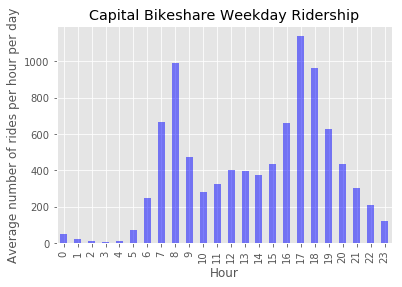

In [152]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', ax=ax)

In [105]:
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days)

Hour
0     122.433206
1      85.811069
2      55.610687
3      29.169847
4      11.259542
5      13.711832
6      38.110687
7      92.805344
8     208.272901
9     365.477099
10    525.019084
11    637.662214
12    714.417939
13    725.458015
14    726.116412
15    714.417939
16    678.406489
17    612.652672
18    522.328244
19    416.603053
20    319.837786
21    240.133588
22    183.368321
23    122.814885
Name: Hour, dtype: float64

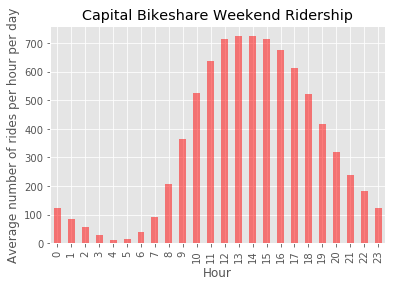

In [153]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Ridership')
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', ax=ax)
plt.show()

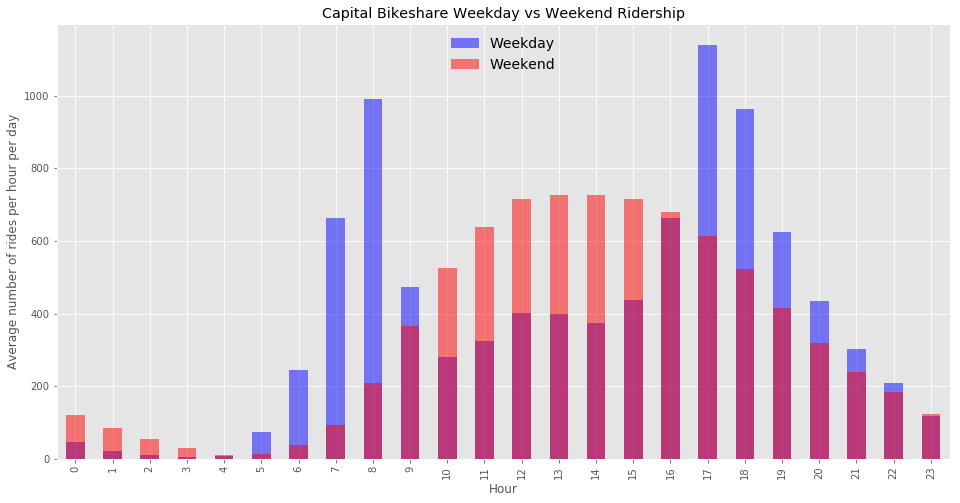

In [116]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday vs Weekend Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekday")
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekend")
plt.legend(frameon=False, fontsize=14, loc=9)

A couple clear take aways, There are two spikes during the work week, one for each rush hour (centered on 8AM and 5PM), where as the weekend data just shows gradual changes with a max between 12:00 PM abd 3:00 PM  

What can we learn about 'Registered' vs 'Casual' riders during each of these time frames?  

(Capital Bikeshare groups their riders based on if they have a long term (registered; Annual Member, 30-Day Member or Day Key Member) or short term (casual; Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass) membership

In [127]:
bikeshare_weekday_casual = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Casual']
bikeshare_weekday_registered = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Registered']
bikeshare_weekend_casual = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Casual']
bikeshare_weekend_registered = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Registered']

In [148]:
print("Average rides of each type per day \n")
print('Weekday Casual: {}'.format(int(len(bikeshare_weekday_casual) / len(business_days))))
print('Weekday Registered: {}'.format(int(len(bikeshare_weekday_registered) / len(business_days))))
print('Weekend Casual: {}'.format(int(len(bikeshare_weekend_casual) / weekend_days)))
print('Weekend Registered: {}'.format(int(len(bikeshare_weekend_registered) / weekend_days)))

Average rides of each type per day 

Weekday Casual: 1441
Weekday Registered: 7769
Weekend Casual: 2946
Weekend Registered: 5215


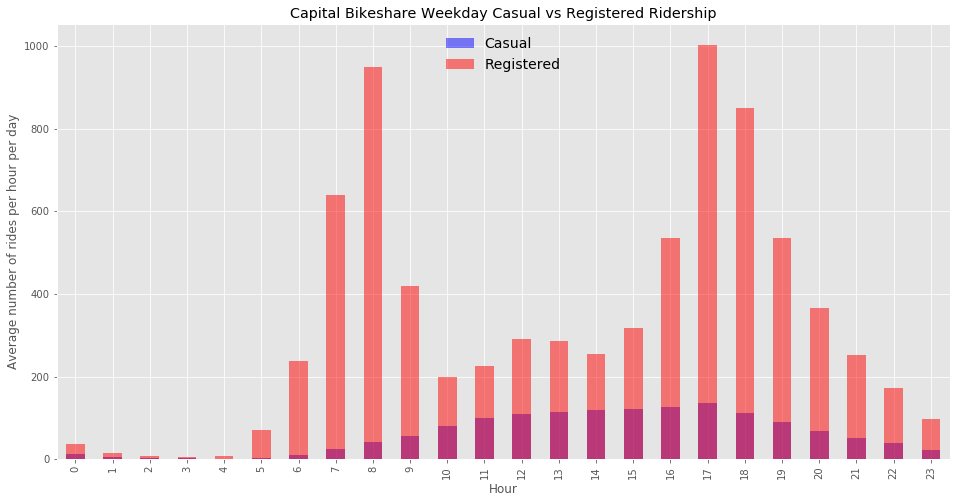

In [131]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Casual vs Registered Ridership')
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=9)

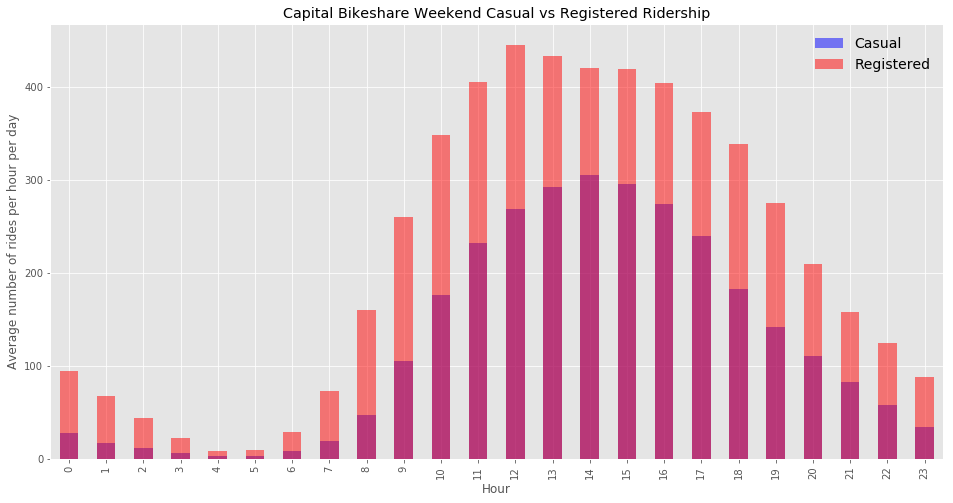

In [139]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Casual vs Registered Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

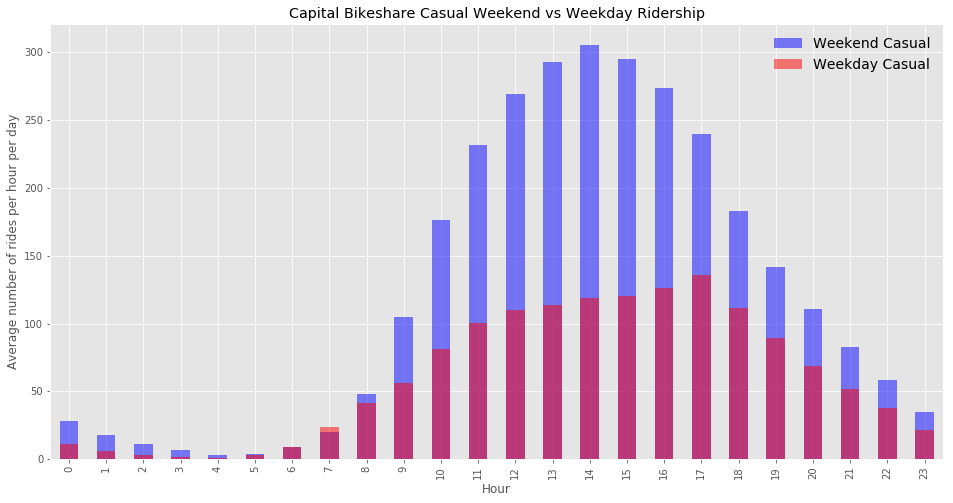

In [135]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Casual Weekend vs Weekday Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Casual")
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Casual")
plt.legend(frameon=False, fontsize=14, loc=1)

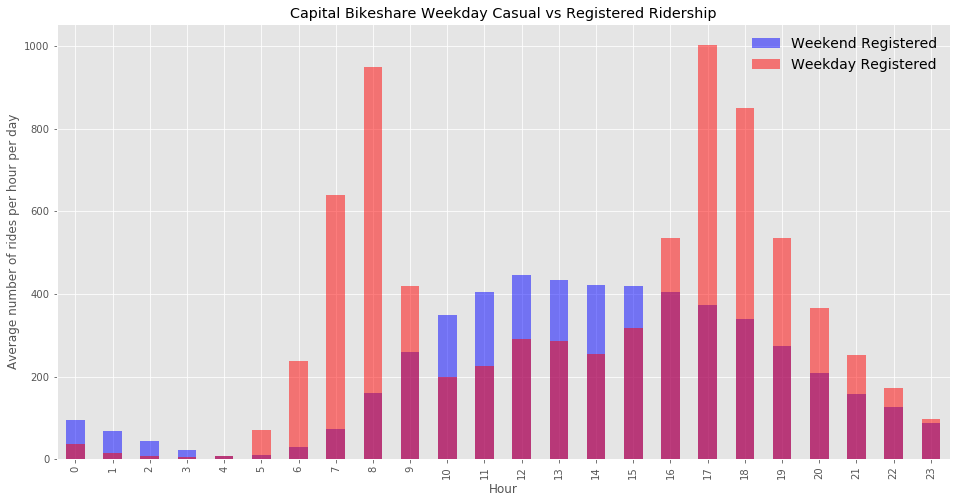

In [138]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Casual vs Registered Ridership')
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Registered")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

Take aways:
* There are more registered than casual riders on both the weekends and weekdays
* during the work week, registered users clearly follow the 'rush hour' pattern, while the casual riders follow a more 'weekend' pattern
* on the weekends, the difference in pattern shape between registered and casual riders is minimal, only the volume of rides is significantly different
* There are many more causal riders on the weekends than on weekdays (~ 2x), but they follow the same pattern shape during both windows
* There are slightly fewer registered weekend riders than weekday riders. This suggets that many of the registered riders are commuters who use the Capital Bikeshare system to get to work

In [149]:
bikeshare_morning_rush = bikeshare_weekday[(bikeshare_weekday['Hour'] >= 6) & (bikeshare_weekday['Hour'] <= 8)]
bikeshare_evening_rush = bikeshare_weekday[(bikeshare_weekday['Hour'] >= 15) & (bikeshare_weekday['Hour'] <= 18)]
bikeshare_no_rush = bikeshare_weekday[~((bikeshare_weekday['Hour'] >= 15) & (bikeshare_weekday['Hour'] <= 18)) &
                                     ~((bikeshare_weekday['Hour'] >= 6) & (bikeshare_weekday['Hour'] <= 8))]


In [150]:
print(bikeshare_morning_rush['Hour'].unique())
print(bikeshare_evening_rush['Hour'].unique())
print(bikeshare_no_rush['Hour'].unique())

[6 7 8]
[15 16 17 18]
[ 0  1  2  3  4  5  9 10 11 12 13 14 19 20 21 22 23]
